# Install Transformers Library

In [ ]:
!pip install transformers==3.0.2

In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import TFAutoModel, AutoTokenizer


# specify GPU
device = torch.device("cuda")

# Import BERT Model and BERT Tokenizer

In [ ]:
BASE_MODEL = 'bert-base-uncased'
bert = AutoModel.from_pretrained(BASE_MODEL)
tokenizer = BertTokenizerFast.from_pretrained(BASE_MODEL)

# Load Dataset

In [ ]:

def data_preprocessing(df):
  """
  Data preprocessing
  """
  for idx, row in df.iterrows():
    query = df.at[idx, 'query']
    question=df.at[idx,'clarifying_question']
    df.at[idx, 'query and question'] = query+'/'+question

  return df

df = pd.read_csv('/train.tsv')
df = data_preprocessing(df)  

# "True" for fine tuning the model with the entire trainset and generating the predictions of validation set or testset.
# "False" for fine tuning the model for debugging
EVALUATION_MODE = False
'''
if EVALUATION_MODE:
  test = pd.read_csv('/test_set.tsv',header=None)
  test_q=test[0].tolist()
  questions=pd.read_csv('/question_bank.tsv',sep='\t')
  test_df = pd.DataFrame()
  for idx, row in test.iterrows():
    query = test.at[idx,0]
    for idxq, rowq in questions.iterrows():
      question=questions.at[idxq,'question']
      id=questions.at[idxq,'question_id']
      test_df=test_df.append([{'query and question': query+'/'+question, 'question_id': id}], ignore_index=True)
  test_df.to_csv('test.tsv') 
'''     

test_df=pd.read_csv('/content/test.tsv')
test = pd.read_csv('/test_set.tsv',header=None)
test_q=test[0].tolist()
questions=pd.read_csv('/question_bank.tsv',sep='\t')

# Split train dataset into train, validation and test sets

In [ ]:

if not EVALUATION_MODE:
  train_text, temp_text, train_labels, temp_labels = train_test_split(df['query and question'], df['label'], random_state=2018, test_size=0.2, stratify=df['label'])
  # Use temp_text and temp_labels to create validation and test set
  val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)
else:
  train_text, val_text, train_labels, val_labels = train_test_split(df['query and question'], df['label'], random_state=2018, test_size=0.1, stratify=df['label'])
  test_text = test_df['query and question']


# Tokenization

In [ ]:
# get length of all the messages in the train set
#seq_len = [len(i.split()) for i in train_text]
max_seq_len = 25    #???
#pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
if not EVALUATION_MODE:
  test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 8      # 4,8,16,     8 for bert  ???

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters 

if 'roberta' not in BASE_MODEL:
  for param in bert.parameters():
    param.requires_grad = False


# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.3)
      
      # Sigmoid activation function works better than nn.ReLU()
      self.activ_fun =  nn.Sigmoid()
      #self.activ_fun =  nn.ReLU()   

      # dense layer 1   
      input_size = 768     
      self.fc1 = nn.Linear(input_size, 512) 
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512, 2)

      #softmax activation function  
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.activ_fun(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-4)  #  e-3,e-4,5e-4  ???

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1. 1.]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# loss function  
cross_entropy  = nn.NLLLoss(weight=weights)


# number of training epochs 
epochs = 1

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels.long())
    
    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels.long())

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

early_stop = 0

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'saved_weights.pt')
      print('### best model with the lowest validation loss is saved ###')
      early_stop = 0
    else:
      early_stop += 1
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    if early_stop == 3:
      # If validation loss increases in 3 epochs, stop the training process
      break


 Epoch 1 / 1
  Batch    50  of  2,414.
  Batch   100  of  2,414.
  Batch   150  of  2,414.
  Batch   200  of  2,414.
  Batch   250  of  2,414.
  Batch   300  of  2,414.
  Batch   350  of  2,414.
  Batch   400  of  2,414.
  Batch   450  of  2,414.
  Batch   500  of  2,414.
  Batch   550  of  2,414.
  Batch   600  of  2,414.
  Batch   650  of  2,414.
  Batch   700  of  2,414.
  Batch   750  of  2,414.
  Batch   800  of  2,414.
  Batch   850  of  2,414.
  Batch   900  of  2,414.
  Batch   950  of  2,414.
  Batch 1,000  of  2,414.
  Batch 1,050  of  2,414.
  Batch 1,100  of  2,414.
  Batch 1,150  of  2,414.
  Batch 1,200  of  2,414.
  Batch 1,250  of  2,414.
  Batch 1,300  of  2,414.
  Batch 1,350  of  2,414.
  Batch 1,400  of  2,414.
  Batch 1,450  of  2,414.
  Batch 1,500  of  2,414.
  Batch 1,550  of  2,414.
  Batch 1,600  of  2,414.
  Batch 1,650  of  2,414.
  Batch 1,700  of  2,414.
  Batch 1,750  of  2,414.
  Batch 1,800  of  2,414.
  Batch 1,850  of  2,414.
  Batch 1,900  of  2,414

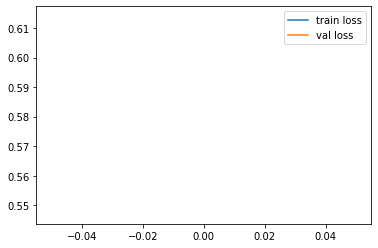

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='val loss')
plt.legend()

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
#一下子输入太多参数导致 CUDA out of memory.

if not EVALUATION_MODE:
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

    # model's performance
  preds_ = np.argmax(preds, axis = 1)  
  print(classification_report(test_y, preds_))

else:
  with open('answer.txt','w') as f:
    for idx,q in enumerate(test_q):
      if idx==0:
        f.write(q+'\t')
      else:
        f.write('\n'+q+'\t')    
      with torch.no_grad():
        preds = model(test_seq[idx*len(questions):(idx+1)*len(questions)].to(device), test_mask[idx*len(questions):(idx+1)*len(questions)].to(device))
        preds = preds.detach().cpu().numpy()
      df = pd.DataFrame({'score': preds[:,1]})
      df=df.sort_values(by='score', ascending=False,ignore_index=False)
      idx=df[:50].index.tolist()
      q_list=[]
      for id in idx:
        f.write(questions.at[id,'question_id']+',')
  f.close() 
  print('f is saved')

f is saved


In [ ]:
with open('answer.txt','w') as f:
    for idx,q in enumerate(test_q[:3]):
      print('question is:',q)
      if idx==0:
        f.write(q+'\t')
      else:
        f.write('\n'+q+'\t')     
      with torch.no_grad():
        preds = model(test_seq[idx*len(questions):(idx+1)*len(questions)].to(device), test_mask[idx*len(questions):(idx+1)*len(questions)].to(device))
        preds = preds.detach().cpu().numpy()
        print('preds shape',preds.shape)
      df = pd.DataFrame({'score': preds[:,1]})
      print(df)
      df=df.sort_values(by='score', ascending=False,ignore_index=False)
      print(df)
      idx=df[:50].index.tolist()
      print(idx)
      for id in idx:
        f.write(questions.at[id,'question_id']+',')
f.close() 
print('f is saved')

question is: Tell me about Computers
preds shape (3999, 2)
         score
0    -0.730644
1    -0.239324
2    -0.460454
3    -0.339163
4    -0.170191
...        ...
3994 -0.325154
3995 -1.285598
3996 -0.641878
3997 -0.087145
3998 -0.302188

[3999 rows x 1 columns]
         score
1876 -0.010264
1886 -0.013094
1953 -0.017589
2229 -0.022993
1918 -0.023408
...        ...
373  -2.030526
521  -2.039295
1464 -2.130960
1113 -2.158965
9    -2.225734

[3999 rows x 1 columns]
[1876, 1886, 1953, 2229, 1918, 2666, 2555, 1936, 3754, 3492, 3491, 2453, 3493, 3940, 3451, 2119, 2136, 3965, 2823, 1884, 1826, 346, 2191, 1997, 1941, 1695, 2083, 3249, 2643, 1563, 3107, 1949, 2141, 2385, 2394, 1565, 2198, 2409, 3578, 1707, 2384, 3342, 639, 1803, 3214, 2892, 2092, 3711, 2462, 2697]
question is: What is a function
preds shape (3999, 2)
         score
0    -0.997211
1    -0.253299
2    -0.315522
3    -0.105348
4    -0.404300
...        ...
3994 -0.398291
3995 -1.014170
3996 -0.487304
3997 -0.100284
3998 -0.24620